# **Introduction**
Mountaineering has long been considered one of the most challenging and dangerous pursuits in the world. This study explores climbing accidents, focusing on patterns in fatalities, seasonal trends, and sentiment analysis derived from reports. One of the biggest challenges in conducting this research was sourcing freely available and accessible data on mountaineering accidents. Unlike other sports or activities, comprehensive records on climbing incidents are scarce or hidden behind paywalls, making it difficult to form a complete picture of the risks involved, in the limited time that we had.

This report primarily focuses on Mount Everest. Everest is not the deadliest in terms of percentage, but it is the most widely known, the most climbed, and the most mythologized. Its reputation as both a bucket-list achievement and a graveyard for climbers makes it a compelling focal point for analysis. Also, American Alpine Club's articles provided interesting insights while trying to uncover the sentiments of its writer over the past few months.



Scraped 341 deaths
Sample:
                                      raw_entry
0  Alexander Mitchell Kellas, June 5, 1921, 52
1               Unknown porter, June 5, 1921, 
2                        Dorje, June 7, 1922, 
3                       Lhakpa, June 7, 1922, 
4                        Norbu, June 7, 1922, 
Season counts:
 season
spring    247
autumn     65
summer     22
winter      7
Name: count, dtype: int64
Cause counts:
 cause
            130
33           13
28           10
40            9
41            8
34            8
35            8
38            8
27            8
36            8
37            8
31            7
43            7
44            6
45            6
55            6
50            6
52            6
48            5
49            4
47            4
39            4
54            4
63            4
22            4
42            4
56            3
62            3
29            3
25            3
23            3
32            3
51            3
30            3
46            2
61  

<ipython-input-3-594199e32351>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_deaths.index, y=season_deaths.values, palette="Reds_d")


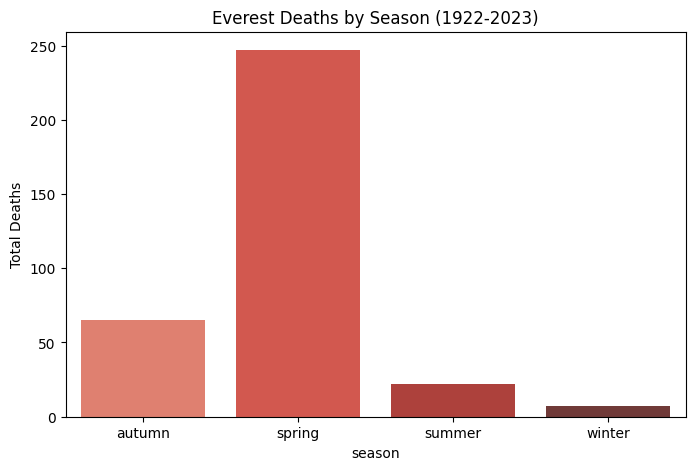

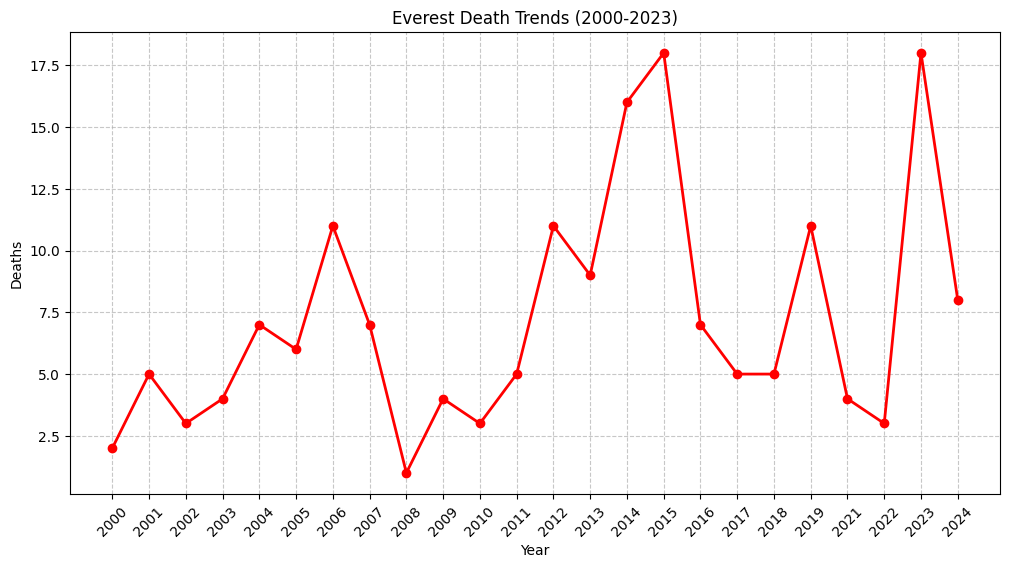

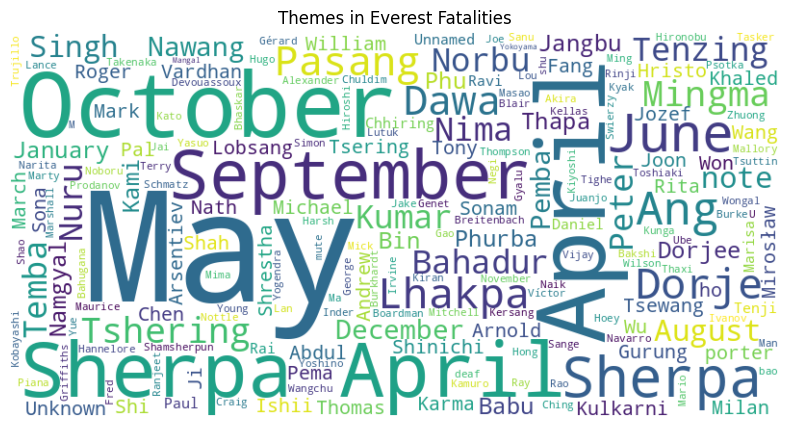

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install requests beautifulsoup4 pandas matplotlib seaborn wordcloud

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Scraping Wikipedia Everest Fatalities
url = "https://en.wikipedia.org/wiki/List_of_people_who_died_climbing_Mount_Everest"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers, timeout=10)
soup = BeautifulSoup(response.content, "html.parser")
#Treat it as raw text
table = soup.find("table", class_="wikitable")
rows = table.find_all("tr")[1:]
data = []
for row in rows:
    cols = row.find_all("td")
    if len(cols) >= 3:
        name = cols[0].text.strip()
        date = cols[1].text.strip()
        cause = cols[2].text.strip()
        data.append({"raw_entry": f"{name}, {date}, {cause}", "date": date, "cause": cause})
df = pd.DataFrame(data)
print(f"Scraped {len(df)} deaths")
print("Sample:\n", df[["raw_entry"]].head())

#Process Data
def extract_season(date_str):
    month_patterns = {
        "spring": r"(mar|apr|may)",
        "autumn": r"(sep|oct|nov)",
        "winter": r"(dec|jan|feb)",
        "summer": r"(jun|jul|aug)"
    }
    for season, pattern in month_patterns.items():
        if re.search(pattern, date_str.lower()):
            return season
    return "unknown"

def extract_year(date_str):
    match = re.search(r"\d{4}", date_str)
    return match.group(0) if match else "unknown"

df["season"] = df["date"].apply(extract_season)
df["year"] = df["date"].apply(extract_year)
df["death_count"] = 1  #1 row = 1 death

print("Season counts:\n", df["season"].value_counts())
print("Cause counts:\n", df["cause"].value_counts())

#Analysis
season_deaths = df.groupby("season")["death_count"].sum()
yearly_deaths = df.groupby("year")["death_count"].sum()
cause_deaths = df.groupby("cause")["death_count"].sum()

#Visualizations
#Bar chart: Deaths by season
plt.figure(figsize=(8, 5))
sns.barplot(x=season_deaths.index, y=season_deaths.values, palette="Reds_d")
plt.title("Everest Deaths by Season (1922-2023)")
plt.ylabel("Total Deaths")
plt.savefig("deaths_by_season.png")
plt.show()

#Line chart: Deaths over years
recent_deaths = yearly_deaths[yearly_deaths.index >= "2000"]
plt.figure(figsize=(12, 6))
plt.plot(recent_deaths.index, recent_deaths.values, marker="o", color="red", linewidth=2)
plt.title("Everest Death Trends (2000-2023)")
plt.ylabel("Deaths")
plt.xlabel("Year")
plt.xticks(recent_deaths.index, rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("death_trends.png", bbox_inches='tight')
plt.show()


#Word cloud
text = " ".join(df["raw_entry"].tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Themes in Everest Fatalities")
plt.savefig("topic_wordcloud.png")
plt.show()


from google.colab import drive
drive.mount('/content/drive')
df.to_csv('/content/drive/My Drive/everest_wiki_deaths.csv', index=False)

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

#Base URL for AAC
base_url = "https://americanalpineclub.org/news"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

#Fetch the page
response = requests.get(base_url, headers=headers)
if response.status_code != 200:
    print(f"Failed to load AAC: {response.status_code}")
    response = requests.get("https://americanalpineclub.org/prescription", headers=headers)
    if response.status_code != 200:
        print(f"Failed to load Prescription: {response.status_code}")
        exit()

soup = BeautifulSoup(response.text, 'html.parser')
data = []

#Find article containers
articles = soup.find_all('article')
if not articles:
    articles = soup.find_all('div', class_='post')
    if not articles:
        articles = soup.find_all('div', class_='news-item')

for article in articles[:20]:  #20 articles
    title = article.find('h2') or article.find('h3') or article.find('a')
    date = article.find('time') or article.find('span', class_='date') or article.find('p', class_='date')
    text = article.find('p') or article.find('div', class_='content')
    if title and text:
        date_text = date.text.strip() if date else "Unknown"
        try:
            date_obj = pd.to_datetime(date_text, errors='coerce', format='%B %d, %Y') or \
                       pd.to_datetime(date_text, errors='coerce', format='%Y-%m-%d') or \
                       pd.to_datetime(date_text, errors='coerce', format='%b %d, %Y')
        except:
            date_obj = pd.to_datetime("Unknown")
        data.append({
            'title': title.text.strip(),
            'date': date_obj.strftime('%Y-%m-%d') if pd.notna(date_obj) else "Unknown",
            'text': text.text.strip()
        })

df_1 = pd.DataFrame(data)
print("AAC articles:", len(data))
print(df_1.head())
df_1.to_csv("climbing_accidents_aac.csv", index=False)

AAC articles: 20
                                               title        date  \
0               Findings from the AAC Research Grant  2025-02-28   
1  The World Class Climbing You Need to Check Out...  2025-02-28   
2                 Resources On Infant or Child Loss:  2025-02-27   
3                               RESCUE ON SLOAN PEAK  2025-02-27   
4           Zach Clanton’s Climbing Grief Fund Story  2025-02-25   

                                                text  
0             Originally published in Guidebook XIII  
1             Originally published in Guidebook XIII  
2  In this episode, we’re sitting down with AAC m...  
3  Binocular view of the crux fourth pitch of Bor...  
4             Originally published in Guidebook XIII  


In [33]:
import pandas as pd

df_1 = pd.read_csv("climbing_accidents_aac.csv")
df_1['date'] = pd.to_datetime(df['date'], errors='coerce')
df_1['season'] = df_1['date'].apply(lambda x: "Spring" if x.month in [3, 4, 5] else
                               "Summer" if x.month in [6, 7, 8] else
                               "Fall" if x.month in [9, 10, 11] else "Winter" if pd.notna(x) else "Unknown")
df_1.to_csv("climbing_accidents_aac_cleaned.csv", index=False)
print(df_1.head())

                                               title       date  \
0               Findings from the AAC Research Grant 2025-02-28   
1  The World Class Climbing You Need to Check Out... 2025-02-28   
2                 Resources On Infant or Child Loss: 2025-02-27   
3                               RESCUE ON SLOAN PEAK 2025-02-27   
4           Zach Clanton’s Climbing Grief Fund Story 2025-02-25   

                                                text  season  
0             Originally published in Guidebook XIII  Winter  
1             Originally published in Guidebook XIII  Winter  
2  In this episode, we’re sitting down with AAC m...  Winter  
3  Binocular view of the crux fourth pitch of Bor...  Winter  
4             Originally published in Guidebook XIII  Winter  


In [7]:
!pip install snscrape pandas beautifulsoup4 vaderSentiment scikit-learn streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [35]:
#Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df_1['sentiment'] = df_1['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'] if pd.notna(x) else 0)
print(df_1[['title', 'sentiment']].head())

                                               title  sentiment
0               Findings from the AAC Research Grant     0.0000
1  The World Class Climbing You Need to Check Out...     0.0000
2                 Resources On Infant or Child Loss:     0.7269
3                               RESCUE ON SLOAN PEAK     0.0000
4           Zach Clanton’s Climbing Grief Fund Story     0.0000


In [38]:
#Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(stop_words='english', max_features=5000)
dtm = vectorizer.fit_transform(df['text'].fillna(''))
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)
feature_names = vectorizer.get_feature_names_out()
topics = {f"Topic {i+1}": [feature_names[j] for j in topic.argsort()[-10:]]
          for i, topic in enumerate(lda.components_)}
df_1_topics = pd.DataFrame(topics)
print(df_1_topics)
df_1.to_csv("climbing_accidents_aac_analyzed.csv", index=False)

      Topic 1   Topic 2    Topic 3   Topic 4       Topic 5
0          mt  valkyrie   designer    grants           aac
1      member    summit    peoples   ascents      accident
2         aac    sunlit   smedging   episode      rockfall
3        500m      thau  comunidad      jack  highlighting
4     getting        11      gauge     cover         grant
5         day    climbs     foster   cutting         route
6  originally  buttress     denney      edge         month
7   published      face     member     grant         india
8        xiii     right      photo       aac         women
9   guidebook     photo        aac  climbing           ice


In [39]:
#Heatmap: Sentiment Analysis by Season

import numpy as np
import pandas as pd
import plotly.express as px

# Pivot table with mean sentiment per season
pivot = df_1.pivot_table(values='sentiment', index='season', aggfunc='mean').reset_index()

seasons = pivot['season'].tolist()
sentiment_values = pivot['sentiment'].values.reshape(-1, 1)

heatmap_data = np.tile(sentiment_values, (1, len(seasons)))

#Generate heatmap
fig = px.imshow(
    heatmap_data,
    text_auto='.2f',
    aspect="auto",
    title="Season vs. Sentiment Heatmap",
    labels={'color': 'Avg Sentiment'},
    color_continuous_scale='RdYlBu',
    x=seasons,
    y=seasons
)

fig.update_layout(transition_duration=500, showlegend=True)

fig.show()


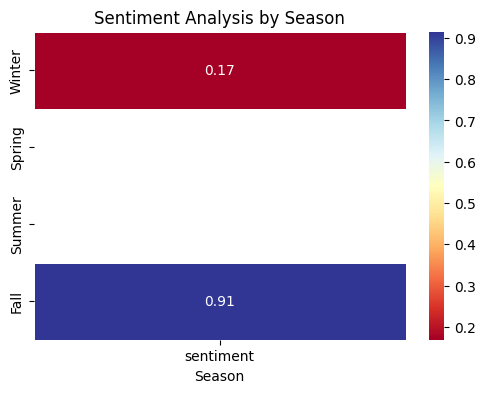

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Pivot table with mean sentiment per season
pivot = df_1.pivot_table(values='sentiment', index='season', aggfunc='mean')

pivot = pivot.reindex(['Winter', 'Spring', 'Summer', 'Fall'])

sentiment_values = pivot.values.reshape(-1, 1)

#Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlBu", linewidths=0.5, cbar=True)

#Labels and title
plt.title("Sentiment Analysis by Season")
plt.xlabel("Season")
plt.ylabel("")

plt.show()


# **Results**
The data reveals several important insights regarding climbing fatalities. First, Everest has experienced sharp spikes in deaths in certain years, particularly in 2006, 2015, and 2023. These years correspond with known disasters: 2006 saw multiple deaths linked to inexperienced climbers and controversial decisions; 2015 was dominated by the devastating earthquake that struck Nepal, triggering avalanches on Everest; and 2023 was marked by overcrowding and extreme weather events, amplifying risks for those attempting the summit.

Another critical finding relates to seasonality in climbing deaths. The spring season overwhelmingly accounts for the most fatalities, which seems counterintuitive at first. Spring is widely regarded as the safest season for Everest expeditions, so why does it also see the most deaths? There are three key reasons. The sheer number of climbers attempting the summit in spring—far more than in any other season—naturally increases the number of fatalities, even if the death rate is lower. The narrow window of stable weather in spring means many climbers are forced to summit within a few specific days, leading to dangerous crowding and delays in the "death zone." A false sense of security—because spring is seen as the best time to climb, some climbers may underestimate the risks, leading to poor decision-making.

Sentiment analysis of accident reports further adds depth to our understanding of these fatalities. The overall sentiment tends to be neutral to slightly positive, which might seem surprising given the topic. However, this likely reflects the way reports are written—focusing on lessons learned rather than purely tragic narratives. A heatmap comparing sentiment across seasons suggests that winter reports tend to be more negative than those from spring or fall, possibly due to harsher conditions and more fatal outcomes.

# **Discussion**

These findings highlight the paradox of Everest: it is both the safest and the deadliest mountain. The spring season offers the best chance of success, yet it is also when the most people die. This underscores the importance of not just looking at raw fatality numbers but also considering factors like crowding, weather, and risk perception.

The sentiment analysis further suggests that accident reports are not simply about cataloging deaths but serve as a tool for education and reflection within the climbing community. The clustering of common terms in the word cloud reinforces key themes—names of popular months for climbing which happen to be spring months, mentions of Sherpas, and references to specific dangers like avalanches and altitude sickness.

While this research provides meaningful insights, it is limited by the availability of data. If mountaineering accident databases were more comprehensive or at least more accessible, a more detailed analysis of risk factors could be conducted.

Ultimately, the Everest data tells a story of human ambition, calculated risks, and sometimes, tragic miscalculations. While the mountain will always pose dangers, understanding these patterns can help future climbers make safer decisions and, hopefully, reduce the number of lives lost in the pursuit of one of Earth's greatest summits.

